## Context Window: Why Chatbots Forget

Every model has a **context window limit** - the maximum number of tokens it can process in a single request.

This includes input + output tokens combined.

Let's see what happens when you exceed it!

In [8]:
from google import genai
from google.genai import types
import os
from dotenv import load_dotenv

load_dotenv(dotenv_path='../.env')
API_KEY = os.environ["GEMINI_API_KEY2"]
client = genai.Client(api_key=API_KEY)

In [9]:
# Create a VERY long message to hit the limit
long_story = "Once upon a time, there was a programmer who loved Python. " * 100000

print(f"📏 Story length: {len(long_story):,} characters")
print(f"📏 Estimated tokens: ~{len(long_story) // 4:,}\n")

try:
    response = client.models.generate_content(
        model="gemini-2.5-flash-lite",
        contents=long_story,
        config={"max_output_tokens": 100}
    )
    print("✅ Request succeeded!")
    print(f"📊 Tokens used: {response.usage_metadata.total_token_count:,}")
    print(f"\n💡 Gemini 2.5 Flash has a HUGE context window (~1M tokens)")
    print(f"   So this request fits comfortably!")
except Exception as e:
    print(f"❌ ERROR: {e}")
    print("\n💡 This is what happens when you exceed the context window!")

📏 Story length: 5,900,000 characters
📏 Estimated tokens: ~1,475,000

❌ ERROR: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/rate-limit. \n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_input_token_count, limit: 250000, model: gemini-2.5-flash-lite\nPlease retry in 49.39167677s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_input_token_count', 'quotaId': 'GenerateContentInputTokensPerMod

### What is Context Window?

**Context Window = Maximum tokens in a single request**

Different models have different limits:
- **Gemini 2.5 Flash**: ~1 million tokens
- **GPT-4**: ~128K tokens
- **Claude 4**: ~200K tokens




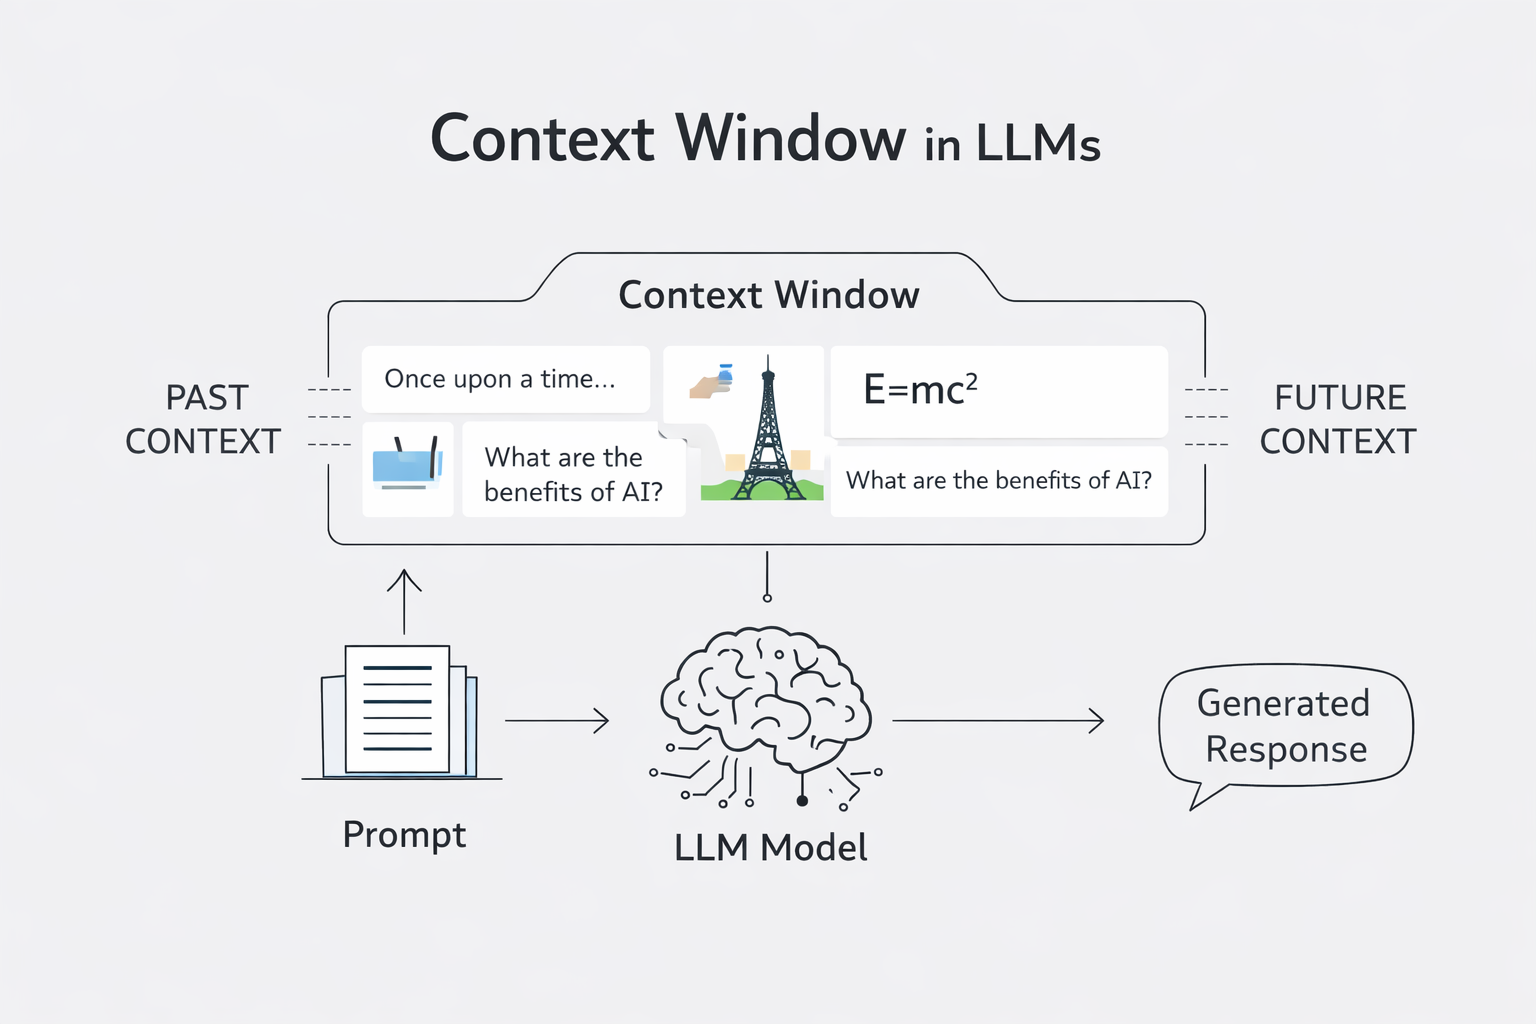

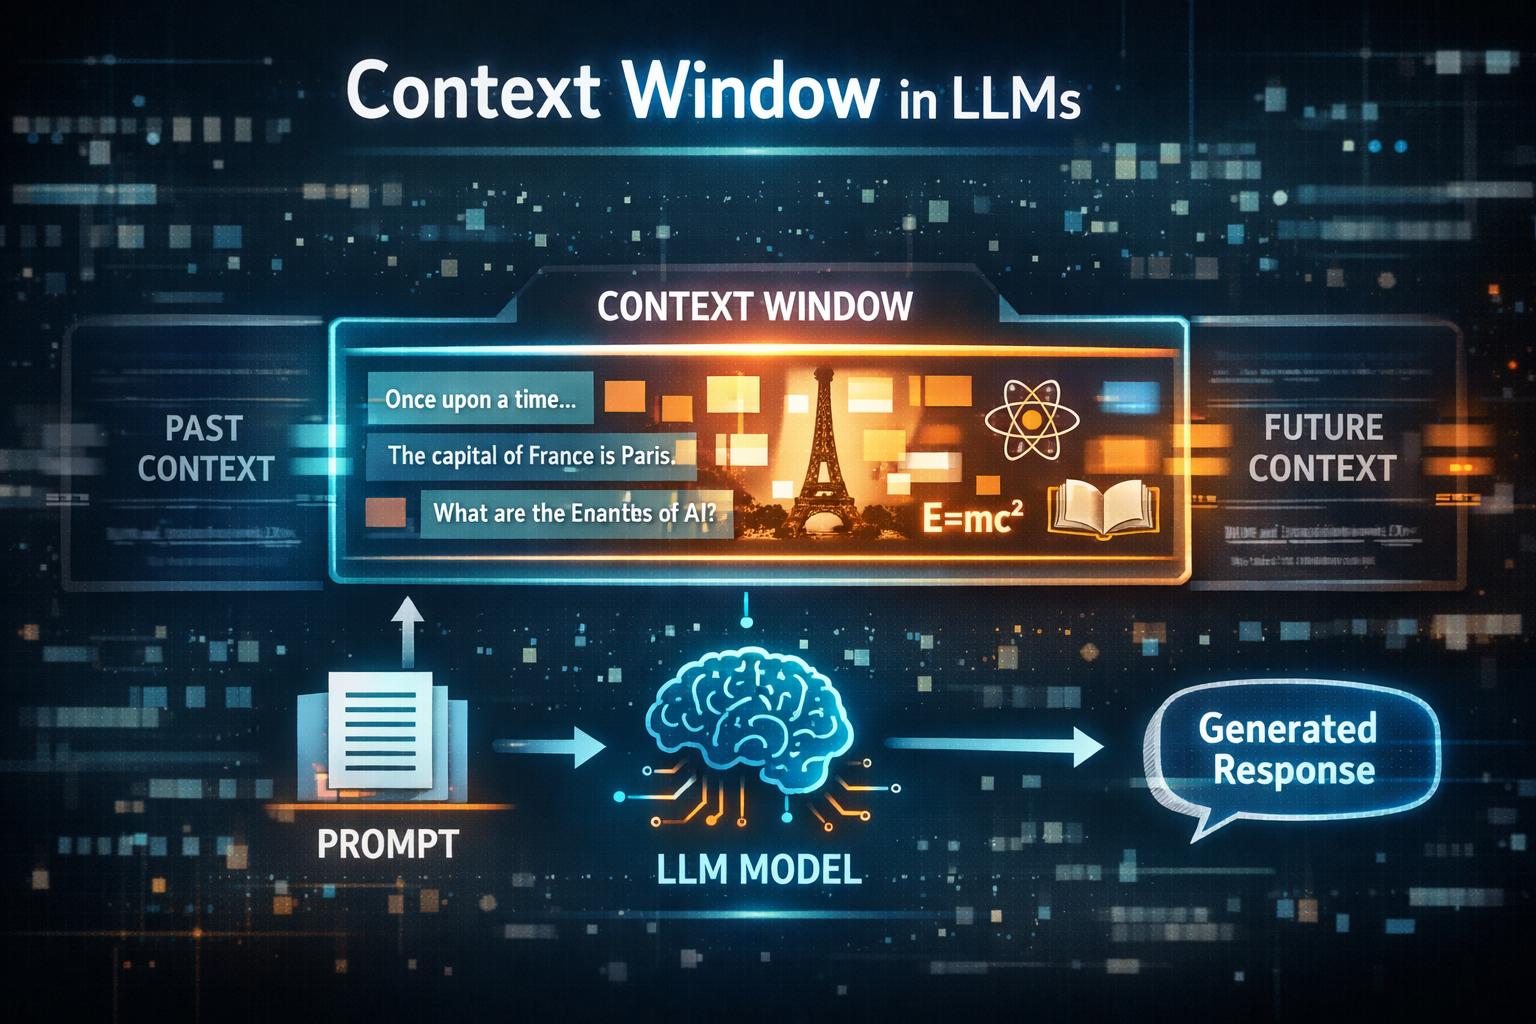

### Context Window in Conversations

In chat applications, the context window includes:
- **All previous messages** (entire conversation history)
- **Current message**
- **Response**

As conversations grow, tokens accumulate!

In [10]:
messages = []

def chat(user_message):
    """Send message and track tokens"""
    messages.append(
        types.Content(role="user", parts=[types.Part(text=user_message)])
    )
    
    response = client.models.generate_content(
        model="gemini-2.5-flash-lite",
        contents=messages
    )
    
    messages.append(
        types.Content(role="model", parts=[types.Part(text=response.text)])
    )
    
    # Show token usage
    total_tokens = response.usage_metadata.total_token_count
    print(f"🤖: {response.text}")
    print(f"📊 Total tokens used: {total_tokens} (includes ALL {len(messages)} messages)\n")
    
    return response.text

# Start conversation
print("👤: Hi! My name is Yash")
chat("Hi! My name is Yash")

print("👤: I'm 25 years old")
chat("I'm 25 years old")

print("👤: I love Python programming")
chat("I love Python programming")

print("👤: I work as a software engineer")
chat("I work as a software engineer")

print("👤: What's my name?")
chat("What's my name?")

👤: Hi! My name is Yash
🤖: Hi Yash! It's nice to meet you. How can I help you today?
📊 Total tokens used: 25 (includes ALL 2 messages)

👤: I'm 25 years old
🤖: Thanks for letting me know, Yash. I'm a large language model, so I don't have an age myself! What's on your mind today?
📊 Total tokens used: 69 (includes ALL 4 messages)

👤: I love Python programming
🤖: That's fantastic, Yash! Python is a really popular and versatile language. What do you enjoy most about it? Are you working on any interesting projects with Python right now?
📊 Total tokens used: 111 (includes ALL 6 messages)

👤: I work as a software engineer
🤖: That's great to hear, Yash! It's always interesting to connect with people in the tech industry. As a software engineer, you probably have a lot of exciting challenges and opportunities.

What kind of software do you typically work on? Are there any particular areas of software engineering that you find most engaging?
📊 Total tokens used: 183 (includes ALL 8 messages)

👤: W

'Your name is Yash!'

### The Problem: Tokens Keep Growing

Notice how tokens increase with each message?

In a real long conversation:
- Message 1: 50 tokens
- Message 10: 500 tokens  
- Message 50: 2,500 tokens
- Message 100: 5,000 tokens
- Message 1000: 50,000 tokens

**Eventually, you'll hit the context window limit!**

### Solution: Remove Old Messages

When approaching the limit, remove oldest messages.

**This is why chatbots "forget"!**

In [11]:
MAX_MESSAGES = 6  # Keep only last 6 messages (3 exchanges)

def chat_with_limit(user_message):
    """Chat with context window management"""
    messages.append(
        types.Content(role="user", parts=[types.Part(text=user_message)])
    )
    
    # Remove old messages if too many
    if len(messages) > MAX_MESSAGES:
        removed = messages.pop(0)  # Remove oldest
        print(f"🗑️  Removed old message: {removed.parts[0].text[:50]}...\n")
    
    response = client.models.generate_content(
        model="gemini-2.5-flash",
        contents=messages
    )
    
    messages.append(
        types.Content(role="model", parts=[types.Part(text=response.text)])
    )
    
    print(f"🤖: {response.text}")
    print(f"📊 Messages in memory: {len(messages)}\n")
    
    return response.text

# Reset and try again
messages = []

print("👤: My favorite color is blue")
chat_with_limit("My favorite color is blue")

print("👤: I have a dog named Max")
chat_with_limit("I have a dog named Max")

print("👤: I live in Mumbai")
chat_with_limit("I live in Mumbai")

print("👤: I enjoy hiking")
chat_with_limit("I enjoy hiking")

# This will forget the first message!
print("👤: What's my favorite color?")
chat_with_limit("What's my favorite color?")

👤: My favorite color is blue
🤖: That's a beautiful choice! Blue is incredibly versatile and often associated with:

*   **Calmness and serenity:** Like the sky or the ocean.
*   **Trust and stability:** Often used in corporate branding.
*   **Wisdom and intelligence.**
*   **Spaciousness and depth.**

Do you have a favorite shade of blue? Like navy, sky blue, cerulean, or something else?
📊 Messages in memory: 2

👤: I have a dog named Max
🤖: Oh, how wonderful! Max is such a classic and friendly name for a dog.

I bet he brings a lot of joy to your life! What kind of dog is Max, and what's his personality like?
📊 Messages in memory: 4

👤: I live in Mumbai
🤖: Mumbai! That's a fascinating and incredibly vibrant city.

It's known for so much – the incredible energy, the iconic Bollywood film industry, delicious street food, historical sites, and its bustling markets.

What's your favorite thing about living in Mumbai?
📊 Messages in memory: 6

👤: I enjoy hiking
🗑️  Removed old message: My fa

"That's a fun question! Unfortunately, as an AI, I don't have any way of knowing personal details like your favorite color unless you tell me directly.\n\nYou've told me about Max, living in Mumbai, and enjoying hiking, but not your color preferences!\n\nSo, what **is** your favorite color? I'm curious to know!"

### Key Takeaways

1. **Context Window** = Maximum tokens in a single request (input + output)

2. **In conversations**, tokens grow with each message

3. **Must remove old messages** when approaching limit

4. **This causes "forgetting"** - AI loses old context

5. **Exceeding limit = Error** - Request will fail

### Real-World Solutions

- **Summarize** old messages instead of removing
- **Store** important info separately (database)
- **Prioritize** recent messages
- **Use RAG** (Retrieval Augmented Generation) for long-term memory
- **Monitor token usage** and manage proactively